In [1]:
import argparse
import pathlib
import random
from collections import deque
from typing import List, Dict, Tuple, Union
from data import Dataset, SuperclassDataset
from data_utils import *
from models import BetaBernoulli
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sampling import *
%matplotlib inline  

import matplotlib;matplotlib.rcParams['font.size'] = 10
import matplotlib;matplotlib.rcParams['font.family'] = 'serif'
LINEWIDTH = 13.97
LOG_FREQ = 10
output_dir = pathlib.Path("../output/difference_random_2_groups")

In [2]:
DATASET_LIST = ['superclass_cifar100', 'dbpedia', '20newsgroup', 'svhn'] #
method_list = ['random_arm_symmetric', 'random_data_symmetric', 'random_arm_informed', \
               'random_data_informed', 'ts_uniform', 'ts_informed']
method_format = {#'random_arm_symmetric': ('Random Arm Symmetric', 'g', '.', '--'), 
                 'random_data_symmetric': ('UPrior', 'b', '^', '--'), 
                 #'random_arm_informed': ('Random Arm Informed', 'g', '.', '-'), 
                 'random_data_informed': ('IPrior', 'b', '^', '-'), 
                 #'ts_uniform': ('TS Symmetric', 'k', '*', '-'), 
                 'ts_informed': ('IPrior+TS', 'r', '+', '-'),
                }

metric = 'difference'
group_method = 'predicted_class'
pseudocount = 2
runs = 100
rope_width = 0.05

In [3]:
configs = {}
samples = {}
mpe_log = {}
rope_eval = {}

for dataset_name in tqdm(DATASET_LIST): # takes 4 minutes to load results of imagenet
    experiment_name = '%s_groupby_%s_pseudocount%.2f' % (dataset_name, group_method, pseudocount)
    samples[dataset_name], mpe_log[dataset_name], rope_eval[dataset_name] = {}, {}, {}
    
    configs[dataset_name] = np.load(open(output_dir / experiment_name / 'configs.npy', 'rb'))
    for method in method_list:
        rope_eval[dataset_name][method] = np.load(open(output_dir / experiment_name / \
                                                       ('rope_eval_%s.npy' % method), 'rb'))

100%|██████████| 4/4 [00:02<00:00,  1.79it/s]


In [4]:
def rope(alpha0, alpha1, beta0, beta1):
    num_samples = 1000
    theta_0 = np.random.beta(alpha0, beta0, size=(num_samples))
    theta_1 = np.random.beta(alpha1, beta1, size=(num_samples))
    delta = theta_0 - theta_1
    return [(delta < -rope_width).mean(), (np.abs(delta) <= rope_width).mean(), (delta > rope_width).mean()]

counts = dict()
budgets = dict()
rope_ground_truth_dict = dict()

for i, dataset_name in enumerate(DATASET_LIST):
        
    counts[dataset_name] = {}
    budgets[dataset_name] = np.zeros((runs,))
    rope_ground_truth_dict[dataset_name] = np.zeros((runs,))
    for method_name in method_format:  
        counts[dataset_name][method_name] = []

    if dataset_name == 'superclass_cifar100':
        superclass = True
        dataset = SuperclassDataset.load_from_text('cifar100', CIFAR100_SUPERCLASS_LOOKUP)
    else:
        superclass = False
        dataset = Dataset.load_from_text(dataset_name)
        
    dataset.group(group_method = group_method)        
    dataset_len = dataset.__len__()
    dataset_accuracy_k = dataset.accuracy_k
    dataset_weight_k = dataset.weight_k
    del dataset
        
    for r in tqdm(range(runs)):
        group0, group1, budget, delta = configs[dataset_name][r]
        group0, group1, budget = int(group0), int(group1), int(budget)
        budgets[dataset_name][r] = budget
        rope_ground_truth = rope(dataset_len * dataset_weight_k[group0] * (dataset_accuracy_k[group0]+ 1e-6), 
             dataset_len * dataset_weight_k[group1] * (dataset_accuracy_k[group1]+ 1e-6), 
             dataset_len * dataset_weight_k[group0] * (1-dataset_accuracy_k[group0] + 1e-6),
             dataset_len * dataset_weight_k[group1] * (1-dataset_accuracy_k[group1] + 1e-6))

        if delta < -rope_width:
            rope_region = 0
        elif delta > rope_width:
            rope_region = 2
        else:
            rope_region = 1
            
        rope_ground_truth_dict[dataset_name][r] = rope_ground_truth[rope_region]
        
        for method_name in method_format:  
            rope_ = rope_eval[dataset_name][method_name][r,:budget//LOG_FREQ, rope_region]
            error_rate = np.abs(rope_ - rope_ground_truth[rope_region]) / rope_ground_truth[rope_region]
            error = (error_rate < 0.05)
            counts[dataset_name][method_name].append(np.argmax(error)*LOG_FREQ+LOG_FREQ)
            #counts[dataset_name][method_name].append(np.abs(rope_[15] - rope_ground_truth[rope_region]))

100%|██████████| 100/100 [00:00<00:00, 4120.38it/s]


In [5]:
val = np.zeros((len(DATASET_LIST), len(method_format)))
for i, dataset_name in enumerate(DATASET_LIST):
    tmp = []
    for method_name in method_format:
        tmp.append(np.mean(counts[dataset_name][method_name]))
    val[i] = np.array(tmp)
df = pd.DataFrame(val.T, 
                  index=[method_format[i][0] for i in method_format], 
                  columns=[DATASET_NAMES[dataset_name] for dataset_name in DATASET_LIST])

In [6]:
print(df.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  CIFAR-100, Superclass &  DBpedia &  20 Newsgroups &   SVHN \\
\midrule
UPrior    &                  215.4 &    250.2 &          207.3 &  379.4 \\
IPrior    &                  145.4 &     96.9 &          182.3 &  155.0 \\
IPrior+TS &                  137.3 &     85.8 &          185.6 &  136.6 \\
\bottomrule
\end{tabular}



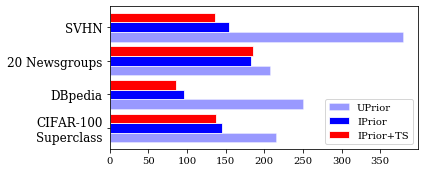

In [7]:
# PLOT
DATASET_NAMES = {
    'cifar100': 'CIFAR-100',
    'imagenet': 'ImageNet',
    'svhn': 'SVHN',
    '20newsgroup': '20 Newsgroups',
    'dbpedia': 'DBpedia',
    'superclass_cifar100': 'CIFAR-100\nSuperclass'
}

# set width of bar
barWidth = 0.8
 
# set height of bar
bars1 = df.values[0]
bars2 = df.values[1]
bars3 = df.values[2]
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))*2.8
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.figure(figsize=(LINEWIDTH//2,2.5))

plt.barh(r1, bars1, color='blue', linewidth=barWidth, edgecolor='white', label='UPrior', alpha=0.4)
plt.barh(r2, bars2, color='blue', linewidth=barWidth, edgecolor='white', label='IPrior', alpha=1)
plt.barh(r3, bars3, color='red', linewidth=barWidth, edgecolor='white', label='IPrior+TS')
 
# Add xticks on the middle of the group bars
# plt.ylabel('group', fontweight='bold')
plt.yticks(r2 , [DATASET_NAMES[dataset_name] for dataset_name in DATASET_LIST], fontsize=12)
 
# Create legend & Show graphic
plt.legend(fontsize=10, loc = 'lower right')
plt.tight_layout()
plt.savefig('../figures/comparison_counts.pdf', dpi=300, bbox_inches='tight', pad_inches=0)

In [8]:
budget_list = []
rope_list = []
for i, dataset_name in enumerate(DATASET_LIST):
    budget_list.append(budgets[dataset_name].mean())
    rope_list.append(rope_ground_truth_dict[dataset_name].mean())
print(budget_list,rope_list)

[997.95, 9997.0, 738.41, 4941.1] [0.9998499999999999, 1.0, 0.89283, 1.0]


In [9]:
dataset = SuperclassDataset.load_from_text('cifar100', CIFAR100_SUPERCLASS_LOOKUP)
dataset.group(group_method = group_method)  
deques = dataset.enqueue()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


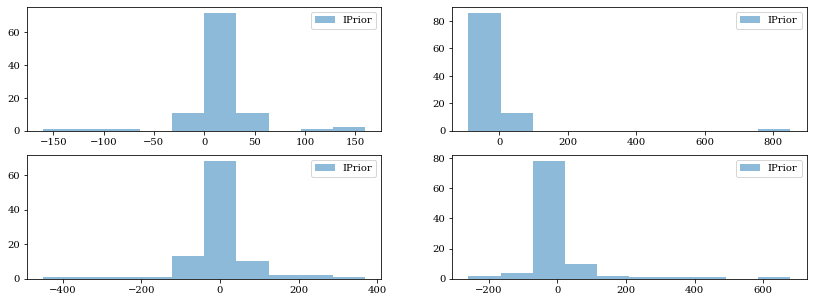

In [55]:
fig, axes = plt.subplots(2, 2, figsize=(LINEWIDTH, 5))
for i, dataset_name in enumerate(DATASET_LIST):
    for method_name in method_format:  
        if method_name == 'random_data_informed':
            axes[i//2, i%2].hist(np.array(counts[dataset_name][method_name])-np.array(counts[dataset_name]['ts_informed']), 
                             alpha=0.5, label=method_format[method_name][0])
            
        axes[i//2, i%2].legend()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


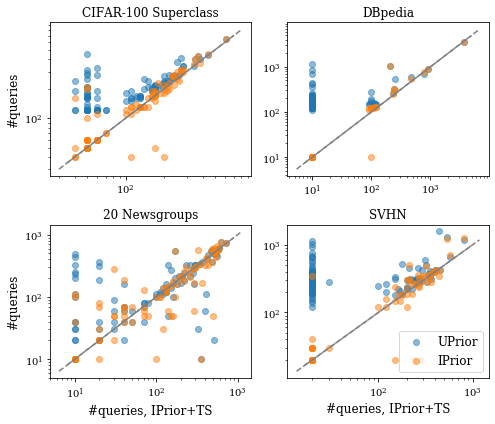

In [57]:
DATASET_NAMES = {
    'cifar100': 'CIFAR-100',
    'imagenet': 'ImageNet',
    'svhn': 'SVHN',
    '20newsgroup': '20 Newsgroups',
    'dbpedia': 'DBpedia',
    'superclass_cifar100': 'CIFAR-100 Superclass'
}

fig, axes = plt.subplots(2, 2, figsize=(LINEWIDTH*0.5, 6))
n = 10000
for i, dataset_name in enumerate(DATASET_LIST):
    for method_name in method_format:  
        if method_name != 'ts_informed':
            axes[i//2, i%2].scatter(counts[dataset_name]['ts_informed'][:n], 
                                counts[dataset_name][method_name][:n],
                                alpha=0.5, label=method_format[method_name][0])
            axes[i//2, i%2].set_xscale('log')
            axes[i//2, i%2].set_yscale('log')
            axes[i//2, 0].set_ylabel('#queries', fontsize=12)
            axes[1, i%2].set_xlabel('#queries, IPrior+TS', fontsize=12)
            axes[i//2, i%2].set_title(DATASET_NAMES[dataset_name])
            axes[i//2, i%2].plot(axes[i//2, i%2].get_xlim(), axes[i//2, i%2].get_xlim(), color='gray', linestyle='--')
    axes[-1,-1].legend(loc='lower right', fontsize=12)
plt.tight_layout()